In [27]:
%matplotlib inline
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from proteus.visu import matrix as visu
from proteus.matrix import tseries as ts
import nibabel as nib
from nibabel.affines import apply_affine
import pandas as pd
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression
from nilearn.masking import compute_epi_mask
from nibabel.affines import apply_affine

In [12]:
subj_id='HC0040123'

In [13]:
# original subject from pierre exp
covar = pd.read_csv('/home/cdansereau/data/deepmotion/cobre/cobre_fmri_preprocess_nii_20161003/resample/fmri_'+subj_id+'_session1_run1_n_confounds.tsv.gz',sep='\t')
covar.columns
vol_nii = nib.load('/home/cdansereau/data/deepmotion/cobre/xp_2016_07_27_final/rest_'+subj_id+'.nii.gz')


In [26]:
vol = vol_nii.get_data()
Xmotion = covar.iloc[:,0:6].values
Xdrift  = covar.iloc[:,8:14].values
fd = covar['FD'].values

In [16]:
ls /home/cdansereau/data/deepmotion/cobre/cobre_fmri_preprocess_nii_20161003/intermediate/HC0040123/motion_correction/

motion_parameters_HC0040123_session1_run1.mat
motion_target_HC0040123_session1_run1.nii.gz
motion_Wrun_HC0040123_session1_run1.mat


In [84]:
dat=sio.loadmat('/home/cdansereau/data/deepmotion/cobre/cobre_fmri_preprocess_nii_20161003/intermediate/'+subj_id+'/motion_correction/motion_Wrun_'+subj_id+'_session1_run1.mat')
dat_parameters=sio.loadmat('/home/cdansereau/data/deepmotion/cobre/cobre_fmri_preprocess_nii_20161003/intermediate/'+subj_id+'/motion_correction/motion_parameters_'+subj_id+'_session1_run1.mat')

ln_motion_affine = dat['transf']
ln_parameters_affine = dat_parameters['transf']

In [51]:
import numpy.linalg as npl
epi_vox2anat_vox = npl.inv(vol_nii.affine).dot(ln_motion_affine[...,0])
#apply_affine(dat['transf'][...,0], vol)


In [53]:
vol_nii.affine

array([[  3.74900937e+00,   0.00000000e+00,   1.04574092e-01,
         -1.17579018e+02],
       [  4.89537641e-02,   3.08637333e+00,  -2.58368921e+00,
         -3.95849724e+01],
       [ -7.09352046e-02,   2.12997651e+00,   3.74381042e+00,
         -1.07464394e+02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [93]:
ln_motion_affine[...,0]

array([[ 0.99990755, -0.00489232, -0.01268803, -0.80346918],
       [ 0.00477247,  0.99994385, -0.00945895,  0.20082903],
       [ 0.01273359,  0.00939753,  0.99987477, -1.95918894],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [92]:
ln_parameters_affine[...,0]

array([[ 0.99990755, -0.00489232, -0.01268803, -0.80346918],
       [ 0.00477247,  0.99994385, -0.00945895,  0.20082903],
       [ 0.01273359,  0.00939753,  0.99987477, -1.95918894],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [128]:
epi_vox2anat_vox[:,:,0]

array([[-24.59420037,   6.21882171, -60.6225368 ,  30.94184508],
       [-20.06162415,   5.23173224, -48.75769331,  24.96502554],
       [-12.11888898,   2.9035064 , -29.37934746,  15.08739372],
       [ -0.80346918,   0.20082903,  -1.95918894,   1.        ]])

In [140]:
npl.inv(vol_tmp.affine)

array([[  2.66596231e-01,   3.48116785e-03,  -5.04427328e-03,
          3.09418451e+01],
       [  1.42369357e-08,   2.19475422e-01,   1.51465009e-01,
          2.49650255e+01],
       [  5.05127818e-03,  -1.24800806e-01,   1.80838557e-01,
          1.50873937e+01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [141]:
vol_tmp.affine

array([[  3.74900937e+00,   0.00000000e+00,   1.04574092e-01,
         -1.17579018e+02],
       [  4.89537641e-02,   3.08637333e+00,  -2.58368921e+00,
         -3.95849724e+01],
       [ -7.09352046e-02,   2.12997651e+00,   3.74381042e+00,
         -1.07464394e+02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [379]:
from nilearn.image import resample_img
ii=1


vol_tmp = nib.Nifti1Image(vol.mean(3),vol_nii.affine)
#affine_trans = np.dot(vol_tmp.affine,ln_motion_affine)
#epi_vox2anat_vox = npl.inv(vol_tmp.affine).dot(ln_motion_affine)
tfm = [[1,0,0,  0],\
       [0,1,0,  0],\
       [0,0,1,-60],\
       [0,0,0,  1]]
new_img = resample_img(vol_tmp,np.dot(npl.inv(ln_motion_affine[:,:,ii]),(vol_nii.affine)),target_shape=vol_tmp.shape)
#new_img = resample_img(vol_tmp,target_affine=np.dot(tfm,vol_nii.affine),target_shape=vol_tmp.shape)


In [316]:
from scipy.interpolate import griddata
from nibabel.affines import apply_affine
import numpy.linalg as npl

values = np.zeros((10,10,10))*1.
values[2:4,2,2] = 1.

mm = np.mgrid[0:10,0:10,0:10]
#mm = mm.swapaxes(0,-1)[0,...]
#print mm.shape
vox_coord = mm.reshape((mm.shape[0],mm.shape[1]*mm.shape[2]*mm.shape[3])).T

#vox_2world_a = np.dot(npl.inv(ln_motion_affine[:,:,ii]),(vol_nii.affine))
translation_affine = np.array([[1, 0, 0, 5],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]])
#scaling_affine = np.array([[ 3.   ,  0.   ,  0.   ,  0.   ],[ 0.   ,  2.866, -0.887,  0.   ],[ 0.   ,  0.887,  2.866,  0.   ],[ 0.   ,  0.   ,  0.   ,  1.   ]])
vox_2world_a = np.dot(translation_affine,vol_nii.affine)

target_aff = vol_nii.affine

#epi_vox2anat_vox = npl.inv(anat_img.affine).dot(epi_img.affine)

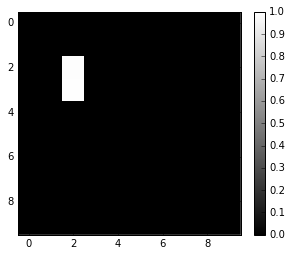

In [296]:
visu.mat(values[:,2,:])

(1000, 3) (10, 10, 10)
0.000571012496948
0.0529971122742


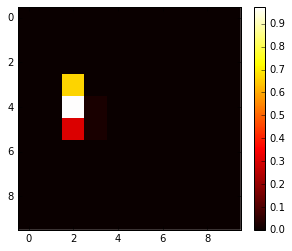

In [372]:
from scipy.interpolate import griddata
from nibabel.affines import apply_affine
import numpy.linalg as npl
import time


def resample_trans(source_vol,source_affine,target_affine,target_shape,affine_trans=np.eye(4)):
    
    # source
    start = time.time()
    grid_source = np.mgrid[0:source_vol.shape[0],0:source_vol.shape[1],0:source_vol.shape[2]]
    vox_coord_vec = grid_source.reshape((grid_source.shape[0],grid_source.shape[1]*grid_source.shape[2]*grid_source.shape[3])).T
    vox_2world_a = np.dot(affine_trans,source_affine)
    
    points = apply_affine(vox_2world_a, vox_coord_vec)
    grid_ = apply_affine(target_affine, vox_coord_vec)
    print points.shape,values.shape
    
    print(time.time() - start)

    # target
    grid_target = np.mgrid[0:target_shape[0],0:target_shape[1],0:target_shape[2]]
    start = time.time()
    # interpolation to the grid
    grid_z1 = griddata(points, source_vol.ravel(), (grid_[...,0], grid_[...,1],grid_[...,2]), method='linear')
    grid_z1 = np.nan_to_num(grid_z1.reshape((source_vol.shape)))
    print(time.time() - start)
    return grid_z1

dd = resample_trans(values,vol_nii.affine,vol_nii.affine,values.shape,translation_affine)
visu.mat(dd[:,2,:])

In [396]:
vol.shape

(64, 64, 33, 150)

In [397]:
coreg_mean_vol = []
for ii in range(vol.shape[3]):
    dd = resample_trans(vol.mean(3),vol_nii.affine,vol_nii.affine,vol.shape[:3],affine_trans=npl.inv(ln_motion_affine[:,:,ii]))
    coreg_mean_vol.append(dd)
    #new_img = nib.Nifti1Image(dd,vol_nii.affine)

(135168, 3) (10, 10, 10)
0.0193121433258
21.7665297985
(135168, 3) (10, 10, 10)
0.00672698020935
21.4048380852
(135168, 3) (10, 10, 10)
0.00610589981079
20.4052479267
(135168, 3) (10, 10, 10)
0.00611591339111
20.3175799847
(135168, 3) (10, 10, 10)
0.00628900527954
22.0591988564
(135168, 3) (10, 10, 10)
0.00594806671143
21.0929498672
(135168, 3) (10, 10, 10)
0.00596189498901
179.530565977
(135168, 3) (10, 10, 10)
0.00699687004089
21.7887117863
(135168, 3) (10, 10, 10)
0.00543403625488
22.8280558586
(135168, 3) (10, 10, 10)
0.0148758888245
21.3930671215
(135168, 3) (10, 10, 10)
0.00545310974121
20.3498539925
(135168, 3) (10, 10, 10)
0.00581407546997
20.3566820621
(135168, 3) (10, 10, 10)
0.00586009025574
20.4874107838
(135168, 3) (10, 10, 10)
0.006178855896
21.2613270283
(135168, 3) (10, 10, 10)
0.00758099555969
22.0493850708
(135168, 3) (10, 10, 10)
0.00583291053772
21.2516129017
(135168, 3) (10, 10, 10)
0.00624895095825
21.7705409527
(135168, 3) (10, 10, 10)
0.00565409660339
21.3785510

In [382]:
new_img = nib.Nifti1Image(coreg_mean_vol[0],vol_nii.affine)

In [378]:
new_img = resample_img(vol_tmp,target_affine=np.dot(tfm,vol_nii.affine),target_shape=vol_tmp.shape)

In [167]:
npl.inv(tfm)

array([[  1.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.],
       [  0.,   0.,   1., -30.],
       [  0.,   0.,   0.,   1.]])

In [150]:
ln_motion_affine[:,:,ii]

array([[ 0.9999373 , -0.00548315, -0.00976218, -0.80430609],
       [ 0.00542643,  0.99996829, -0.00582724,  0.16427231],
       [ 0.00979382,  0.0057739 ,  0.99993533, -2.26354361],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [183]:
vol_tmp.affine

array([[  3.74900937e+00,   0.00000000e+00,   1.04574092e-01,
         -1.17579018e+02],
       [  4.89537641e-02,   3.08637333e+00,  -2.58368921e+00,
         -3.95849724e+01],
       [ -7.09352046e-02,   2.12997651e+00,   3.74381042e+00,
         -1.07464394e+02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [184]:
new_img.affine

array([[  3.74834536e+00,   3.76086050e-02,   1.27213553e-01,
         -1.18013409e+02],
       [  2.79862588e-02,   3.09857378e+00,  -2.56256433e+00,
         -3.97151108e+01],
       [ -1.07814404e-01,   2.11185390e+00,   3.75760351e+00,
         -1.03822451e+02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [159]:
np.dot(npl.inv(ln_motion_affine[:,:,ii]),(vol_nii.affine))

array([[  3.74834536e+00,   3.76086050e-02,   1.27213553e-01,
         -1.18013409e+02],
       [  2.79862588e-02,   3.09857378e+00,  -2.56256433e+00,
         -3.97151108e+01],
       [ -1.07814404e-01,   2.11185390e+00,   3.75760351e+00,
         -1.03822451e+02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [174]:
print vol_tmp.shape
print new_img.shape

(64, 64, 33)
(64, 69, 39)


(1000, 3) (10, 10, 10)


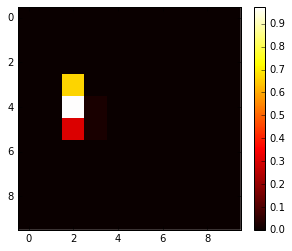

In [370]:
dd = resample_trans(values,vol_nii.affine,vol_nii.affine,values.shape,translation_affine)
visu.mat(dd[:,2,:])

In [59]:
# R2 score
def getR2(y,ypred):
    R2 = 1. - np.sum((y-ypred)**2,0)/np.sum(y**2,0)
    return R2 

def getMap(val,mask):
    if len(val.shape)==2:
        new_map = np.zeros((mask.shape[0],mask.shape[1],mask.shape[2],val.shape[1])).astype(float)
    else:
        new_map = np.zeros_like(mask).astype(float)
    new_map[mask] = val
    return new_map

def getspec(vol):
    nx,ny,nz = vol.shape
    nrows = int(np.ceil(np.sqrt(nz)))
    ncolumns = int(np.ceil(nz/(1.*nrows)))
    return nrows,ncolumns,nx,ny,nz

def montage(vol1):

    vol = np.swapaxes(vol1,0,1)
    nrows,ncolumns,nx,ny,nz = getspec(vol)

    mozaic = np.zeros((nrows*nx,ncolumns*ny))
    indx,indy = np.where(np.ones((nrows,ncolumns)))

    for ii in np.arange(vol.shape[2]):
        # we need to flip the image in the x axis
        mozaic[(indx[ii]*nx):((indx[ii]+1)*nx),(indy[ii]*ny):((indy[ii]+1)*ny)] = vol[::-1,:,ii]

    return mozaic

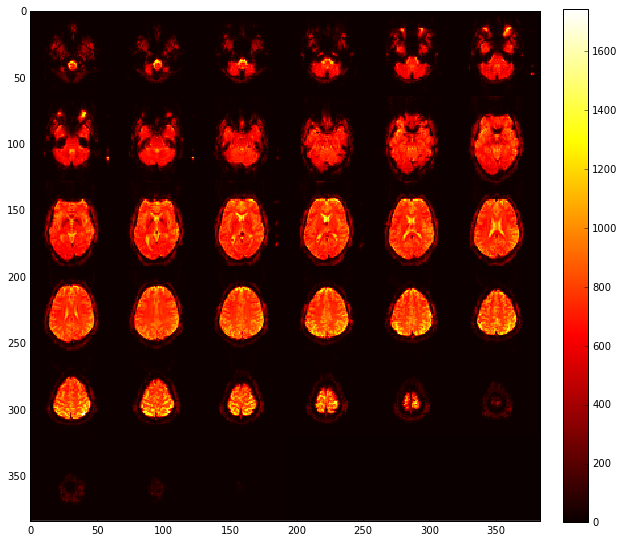

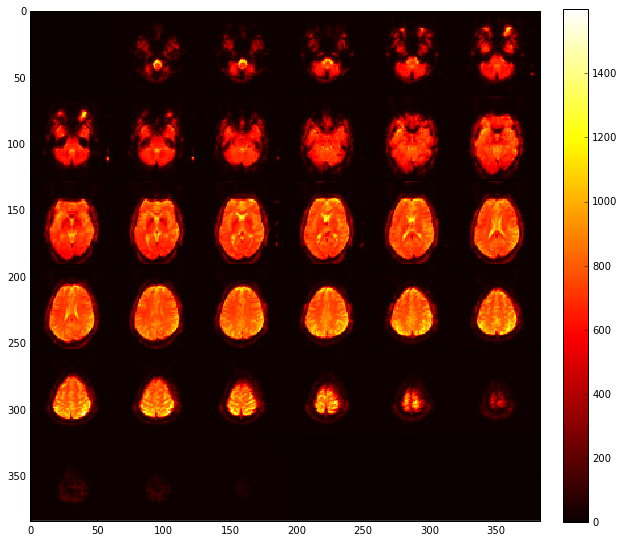

In [384]:
plt.figure(figsize=(10,10))
visu.mat(montage(vol_tmp.get_data()))

plt.figure(figsize=(10,10))
visu.mat(montage(new_img.get_data()))

In [398]:
len(coreg_mean_vol)

150

In [399]:
np.array(coreg_mean_vol).shape

(150, 64, 64, 33)

In [ ]:
X = Xmotion
y = vol - coreg_mean_vol
y = y[mask_b].T

lreg_drift = LinearRegression(fit_intercept=True)
lreg_drift.fit(Xdrift,y)
new_y = y-lreg_drift.predict(Xdrift)

lreg_motion = LinearRegression(fit_intercept=True)
lreg_motion.fit(Xdrift,Xmotion)
new_Xmotion = Xmotion - lreg_motion.predict(Xdrift)

lreg = LinearRegression(fit_intercept=False)
lreg.fit(new_Xmotion,new_y)

ypred = lreg.predict(new_Xmotion)
R2 = getR2(new_y,ypred)

print 'Average R2: ',R2.mean()